# Determinants of Box Office Success

## Import Modules and Data

In [234]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.stats import iqr

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
movies = pd.read_csv('movie_data.csv')

## Explore and Clean Dataset

In [43]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_reviews         4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_users_voted            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [44]:
# remove duplicate rows based on the 'movie_title' and 'title_year' column
movies.drop_duplicates(subset=['movie_title','title_year'], keep=False, inplace=True)

# reset index
movies.reset_index(drop=True, inplace=True)

In [137]:
# replace zeros in budget and gross columns with NaN
movies['budget'] = movies['budget'].replace(0, np.NaN)
movies['gross'] = movies['gross'].replace(0,np.NaN)

# transform budget and gross metrics to show in millions
movies['budget_millions'] = round(movies['budget'] / 1000000, 4)
movies['gross_millions'] = round(movies['gross'] / 1000000, 4)

# add calculated columns
movies['profit_millions'] = movies['gross_millions'] - movies['budget_millions']
movies['roi'] = (movies['profit_millions'] / movies['budget_millions'])
movies['profit_margin'] = movies['profit_millions'] / movies['gross_millions']

### Remove irrelevant movies
The dataset contains movies that are not relevant to the move studio's current strategy, including movies from as early as 1916 and non-English language movies. I filtered <code>movies</code> to exclude all movies released prior to 1996 and all non-English language movies.

In [138]:
# remove all movies from before the year 1996 in order to focus on the most recent data points
movies = movies[movies['title_year']>=1996]

# keep only English language movies
movies = movies[movies['language'] == 'English']

# reset index
movies.reset_index(drop=True, inplace=True)

### Explore Numeric Variables

In [247]:
movies.describe()

,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_users_voted,cast_total_facebook_likes,num_user_reviews,budget,...,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes,budget_millions,gross_millions,profit_millions,roi,profit_margin,profit_millions_norm
count,3594.000000,3622.000000,3631.000000,3617.000000,3625.000000,3.192000e+03,3.631000e+03,3631.000000,3617.000000,3.341000e+03,...,3623.000000,3631.000000,3386.000000,3631.000000,3341.000000,3192.000000,2982.000000,2982.000000,2982.000000,2982.000000
mean,153.584864,105.881005,607.035527,719.228090,7353.553103,4.835620e+07,8.478490e+04,10854.106582,285.698092,3.705414e+07,...,1856.759868,6.273120,2.159338,8359.975213,37.054139,48.356203,10.205826,5.254618,-39.832713,1.000000
std,125.332016,19.350855,2673.283090,1787.452942,16377.690434,6.784123e+07,1.355017e+05,19643.965493,392.308665,4.413287e+07,...,4379.039825,1.099651,0.833793,21180.567963,44.132871,67.841232,51.715350,148.874059,860.296987,5.067238
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,1.000000,2.180000e+02,...,0.000000,1.600000,1.330000,0.000000,0.000200,0.000200,-598.397500,-0.999978,-44999.000000,-58.632934
25%,62.000000,93.000000,8.000000,179.000000,701.000000,5.746694e+06,9.248500e+03,1752.000000,70.000000,8.000000e+06,...,352.000000,5.700000,1.850000,0.000000,8.000000,5.746675,-11.006600,-0.554268,-1.243503,-1.078462
50%,126.000000,102.000000,47.000000,422.000000,1000.000000,2.559138e+07,3.583400e+04,3690.000000,165.000000,2.200000e+07,...,651.000000,6.400000,2.350000,199.000000,22.000000,25.591350,0.053300,0.003857,0.003842,0.005223
75%,212.000000,116.000000,181.000000,680.000000,12000.000000,6.203284e+07,9.999500e+04,15270.000000,347.000000,5.000000e+07,...,960.000000,7.000000,2.350000,5000.000000,50.000000,62.032850,21.414100,0.939770,0.484475,2.098223
max,813.000000,280.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.676169e+06,656730.000000,5060.000000,6.000000e+08,...,137000.000000,9.000000,16.000000,349000.000000,600.000000,760.505800,523.505800,7193.486667,0.999861,51.294802


#### Remove outliers
After a preliminary exploration of the numeric variables, it became apparent that several of the numeric variables have significant outliers. The inclusion of outliers will make it more difficult to accurately assess the distribution of the variables and relationships between variables. I trimmed numeric variables by replacing outliers with upper whisker values. Outliers are identified using the IQR method; replace outliers with upper whisker value; trimmed values are stored in <code>movies_trimmed</code>.

In [248]:
# define movies_trimmed df to hold trimmed variables
movies_trimmed = movies.copy(deep = True)

In [249]:
# separate numerical fields from categorical
movies_numeric = movies.select_dtypes(include=['float64', 'int64'])

# replace outliers with upper whisker / lower whisker value
for column in movies_numeric:
    q1 = movies_trimmed[column].quantile(0.25)
    q3 = movies_trimmed[column].quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + (iqr*1.5)
    lower_whisker = q1 - (iqr*1.5)
    movies_trimmed.loc[movies_trimmed[column] > upper_whisker, column] = upper_whisker
    movies_trimmed.loc[movies_trimmed[column] < lower_whisker, column] = lower_whisker

Text(0.5, 1.0, 'ROI without outliers')

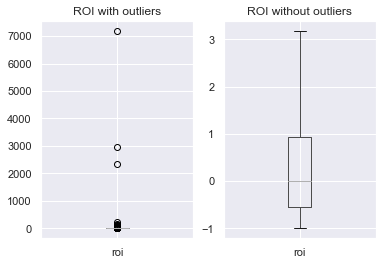

In [250]:
# create 1x2 array of subplots
fig, axes = plt.subplots(nrows=1, ncols=2) 

# add boxplot to 1st subplot
movies.boxplot(column='roi', ax=axes[0]).set_title("ROI with outliers")

# add boxplot to 2nd 
movies_trimmed.boxplot(column='roi', ax=axes[1]).set_title("ROI without outliers")

#plt.show()

#plt.savefig('boxplot_roi_compare.png')

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Dollar metrics without outliers')

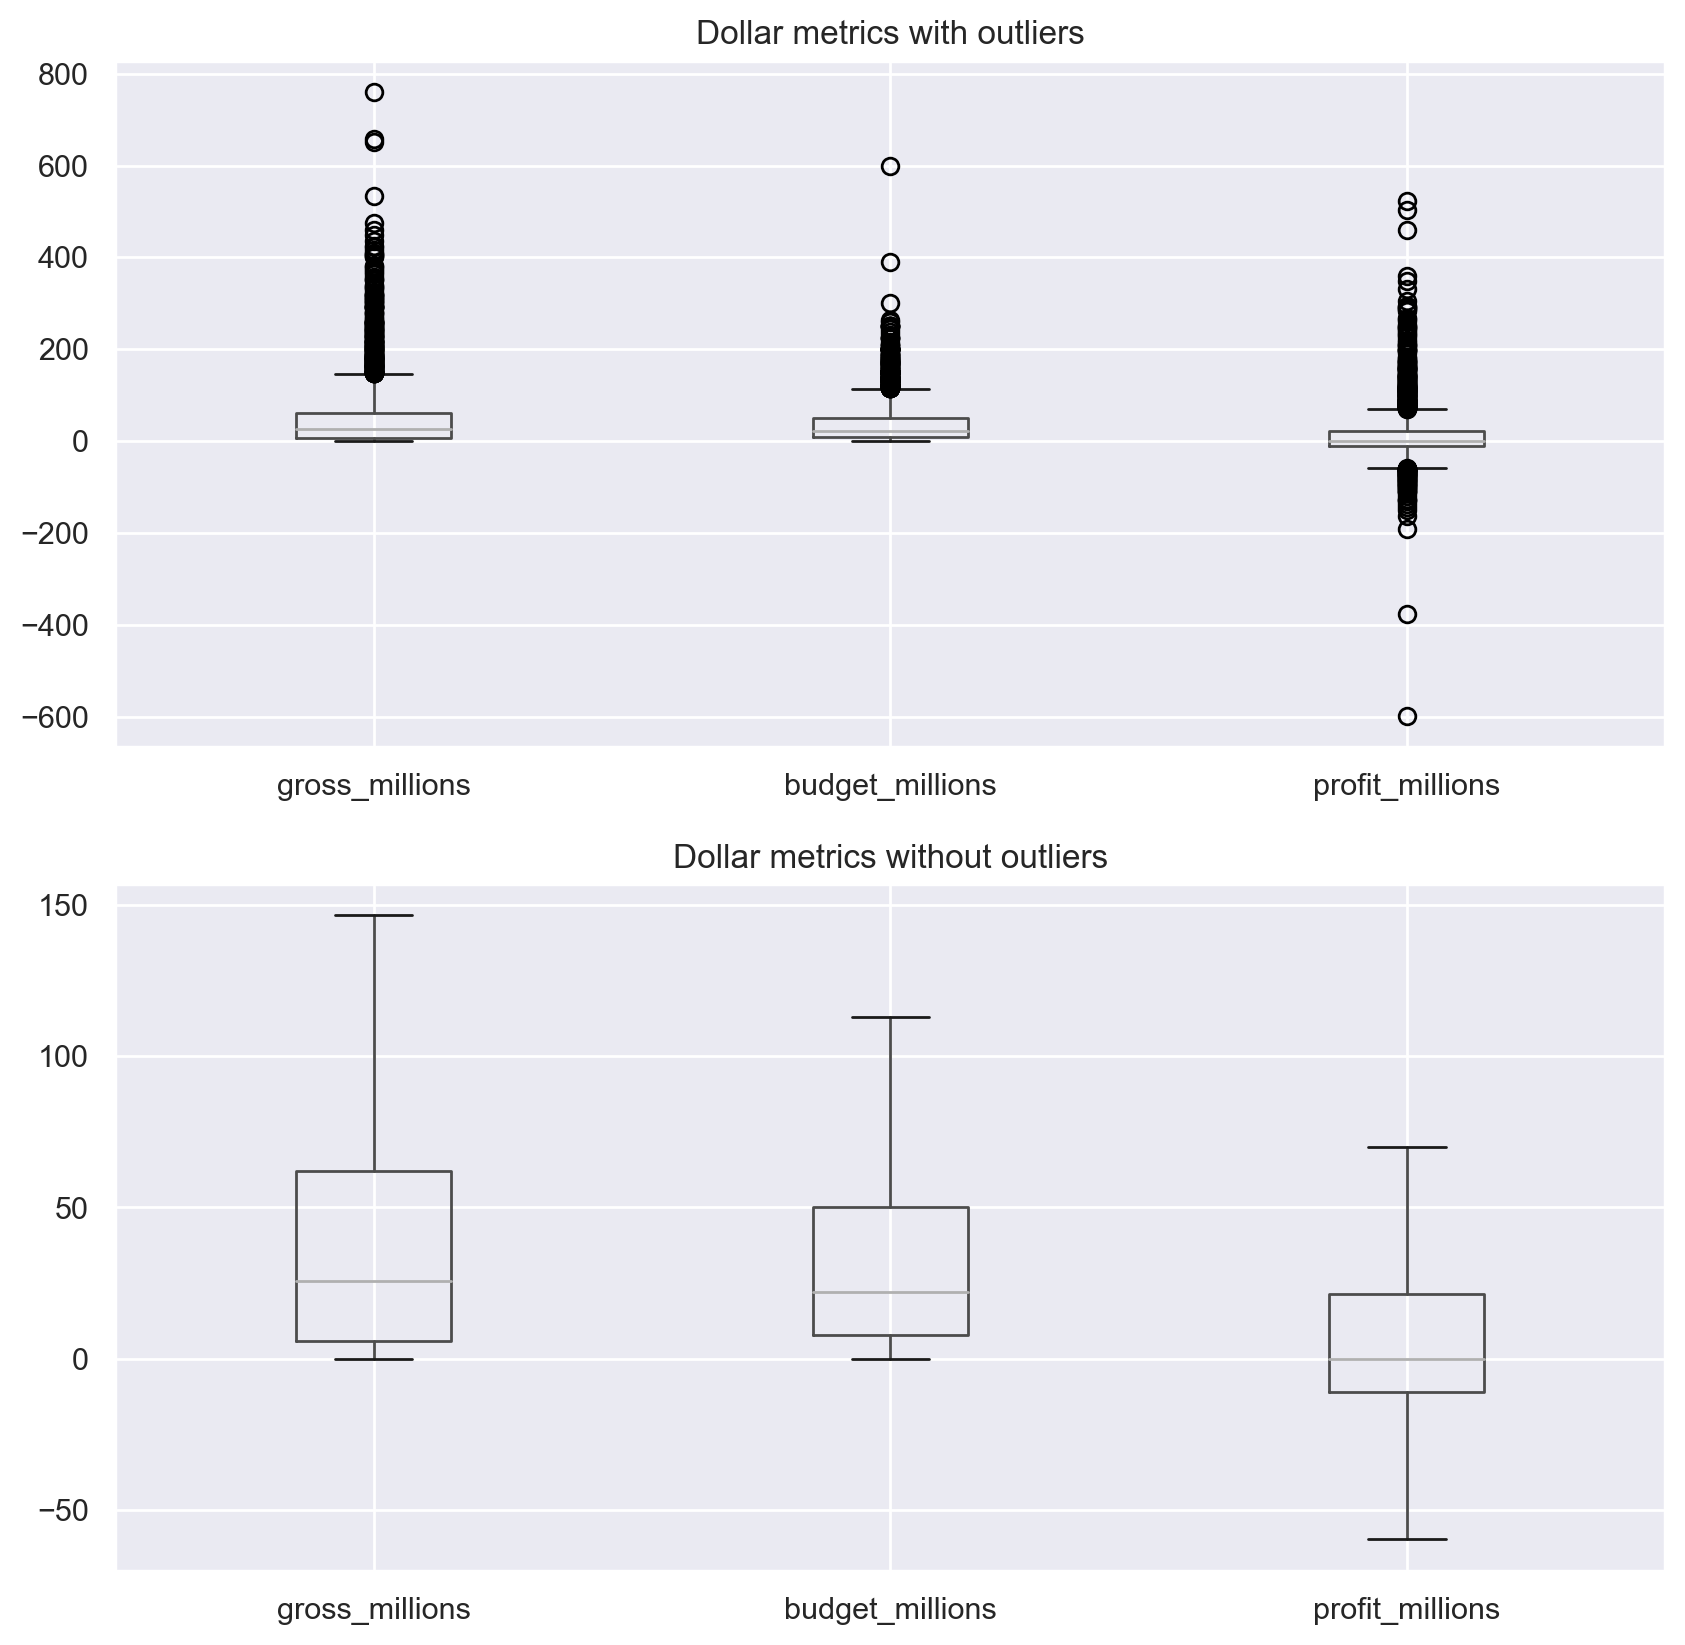

In [251]:
# create 2x1 array of subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10), dpi = 200) 

# add boxplot to 1st subplot
movies.boxplot(column=['gross_millions','budget_millions','profit_millions'], ax=axes[0]).set_title("Dollar metrics with outliers")

# add boxplot to 2nd 
movies_trimmed.boxplot(column=['gross_millions','budget_millions','profit_millions'], ax=axes[1]).set_title("Dollar metrics without outliers")

#plt.savefig('boxplot_dollar_metrics_compare.png')

### Explore Relationships between numeric variables

Variables moderately correlated (correlation > 0.4) with gross revenue:
* <code>num_critic_reviews</code>
* <code>num_users_voted</code>
* <code>num_user_reviews</code>
* <code>budget</code>
* <code>profit_millions</code>
* <code>roi</code>
* <code>profit_margin</code> 
<br><br>

Variables moderately correlated (correlation > 0.4) with profit:
* <code>gross_millions</code>
* <code>num_users_voted</code>
* <code>roi</code>
* <code>profit_margin</code>
<br><br>

Variables that are moderately correlated (correlation > 0.4) with profit margin:
* <code>gross_millions</code>
* <code>roi</code>
* <code>profit_margin</code>
<br><br>

Variables that are moderately correlated (correlation > 0.4) with ROI:
* <code>gross_millions</code>
* <code>profit_millions</code>
* <code>profit_margin</code>

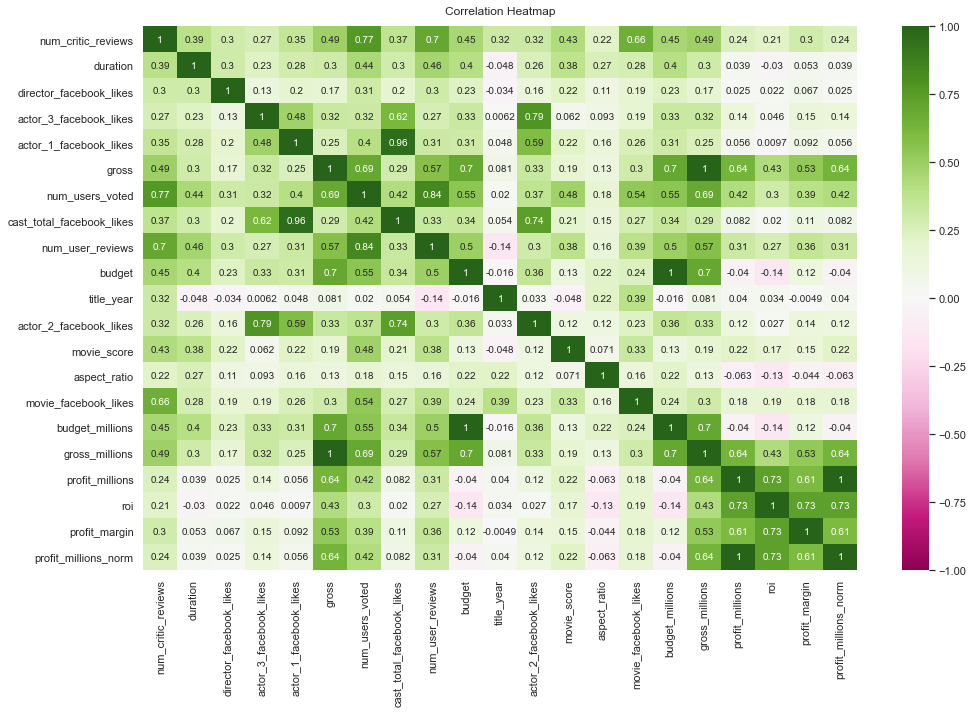

In [252]:
# define correlation matrix using movies_trimmed
corr_matrix_trimmed = movies_trimmed.corr()

# create heatmap using correlation matrix
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr_matrix_trimmed, vmin=-1, vmax=1,cmap="PiYG", annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# save correlation matrix to csv
#corr_matrix_trimmed.to_csv('corr_matrix_trimmed.csv')
plt.savefig('heatmap.png')

### Explore Categorical Variables

In [253]:
movies['director_name'].value_counts().head()

Steven Spielberg     15
Woody Allen          15
Clint Eastwood       14
Steven Soderbergh    13
Ridley Scott         12
Name: director_name, dtype: int64

In [254]:
movies['actor_1_name'].value_counts().head()

Robert De Niro    33
Matt Damon        28
J.K. Simmons      27
Nicolas Cage      27
Johnny Depp       25
Name: actor_1_name, dtype: int64

In [255]:
movies['actor_2_name'].value_counts().head()

Morgan Freeman     13
Charlize Theron    13
Brad Pitt          10
Adam Sandler       10
Will Ferrell        9
Name: actor_2_name, dtype: int64

In [256]:
movies['actor_3_name'].value_counts().head()

Steve Coogan    8
Stephen Root    7
Sam Shepard     6
Shawn Hatosy    6
Bruce McGill    6
Name: actor_3_name, dtype: int64

In [257]:
movies['genres'].value_counts().head()

# genres will be more effectively analyzed by separating the genres

Comedy                  169
Drama                   164
Comedy|Drama            154
Comedy|Drama|Romance    148
Comedy|Romance          139
Name: genres, dtype: int64

In [258]:
movies['plot_keywords'].value_counts().head()

# plot keywords will be more effectively analyzed by separating the keywords

nan                      111
based on novel             3
one word title             3
after dark horrorfest      2
two word title             2
Name: plot_keywords, dtype: int64

In [259]:
movies['country'].value_counts().head()

USA        2907
UK          317
Canada       99
France       78
Germany      75
Name: country, dtype: int64

In [260]:
movies['content_rating'].value_counts().head()

R            1598
PG-13        1223
PG            467
G              74
Not Rated      64
Name: content_rating, dtype: int64

# Analysis

After exploring the data through EDA, I decided to focus on 4 inputs, and two determinants of success: 
- Inputs (factors the studio can control)
  - actors (<code>actor_1_name</code>, <code>actor_2_name</code>, <code>actor_3_name</code>)
  - directors (<code>director_name</code>)
  - genres (<code>genres</code>)
  - plot keywords (<code>plot_keywords</code>)
- Determinants of success
  - profit (<code>profit_millions</code>)
  - roi (<code>roi</code>)

I also used normalized profit (<code>profit_millions_norm</code>). Profit is normalized by dividing each individual value by the average profit for all movies in our dataset. These normalized values allow me to analyze a variable's percent distance from the mean (i.e. a normalized value is 1.07 means that the variable is 7% above the mean).

I chose to ignore the non-monetary metrics that represent the popularity of a movie's actors and director (the Facebook likes the actors and director) because they have weak or non-existent correlations with the monetary metrics of a movie’s success. Moreover, Facebook didn’t exist for the entire period of time we are analyzing, and the populations that use Facebook and its various features has changed dramatically over the past 15 years.  
<br>
I assume that the financial metrics of a movie’s success are most relevant to the movie studio’s decision-making processes, and therefore will not consider the non-monetary metrics of a movie’s success in the analysis.
<br> <br>
I chose not to include profit margin(<code>profit_margin</code>) because this analysis aims to identify which elements lead to successful movies - not cost-cutting or pricing strategies which might be better captured by profit margin. Moreover, profit margin is highly correlated with ROI, so movies with strong profit margins will likely be captured in ROI analysis.

In [156]:
# define noramlized profit metric
movies['profit_millions_norm'] = movies['profit_millions'] /movies['profit_millions'].mean()

## Actor Analysis
<br>
Do certain actors tend to make more financially successful movies?
<br><br>
This analysis focuses on experienced actors - those who have been a lead actor in at least 4 movies, or a supporting actor in at least 4 movies.
<br><br>
I analyze the outcomes for the lead actor in a movie (<code>actor_1_name</code>) separately from the outcomes for the supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>), because lead actors likely influence audience decisions to see movies in a different way than supporting actors. This method is imperfect, because some movies have more than one headliner, and some have ensemble casts - these realities are not reflected in the data we have available. Therefore, the resulting lists of lead actors with strong financial outcomes may leave out some actors who were not coded as <code>actor_1_name</code> in the movies they starred in. However, this analysis will provide a strong starting point for identifying which actors appear in movies with the strongest financial outcomes.

### 1. Profit per actor (normalized)
Calculating profit per actor, as a percentage of average profit, normalizes the profit metric and allows for analysis of how each actor's average profit compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.

### 1.1 Lead actor
**Method**<br>
(1) filter <code>movies</code> to show only actors who have appeared as the lead actor (<code>actor_1_name</code>) in at least 4 movies; <br>
(2) calculate average profit per actor; <br>
(3) divide average profit per actor by overall average profit for all movies to arrive at normalized profit.
(4) create list of all actors with an average normalized profit greater than <code>profit_baseline</code>.
<br><br>
Profit baseline is set at the 75th percentile, which is equal to 2.09; a normalized profit of 2 indicates that the average profit per actor is equal to twice the overall average profit (a value of 1 is an average value).
<br>
<br>
**Result**<br>
There are 47 lead actors (<code>actor_1_name</code>) with a normalized profit value greater than the profit baseline (2.09) - indicating that the movies in which these actors are the headliner (<code>actor_1_name</code>) have an average profit that is at least twice the overall average.
<br><br>
**Recommendations**<br>
The lead actors with an average normalized profit greater than the profit baseline have a track record of appearing in movies with strong financial results, and should be hired on future movies.

In [157]:
# define values to be used to as filters
num_movies_acted = 4
profit_baseline = movies['profit_millions_norm'].quantile(0.75)
roi_baseline = movies['roi'].quantile(0.75)

In [158]:
# actor1 (lead actors)
# calculate number of movies per actor
actor1_counts = movies['actor_1_name'].value_counts()

# create a list that contains all experienced lead actors
actor1_list = actor1_counts[actor1_counts >= num_movies_acted].index.tolist()

# filter movies df to show only experienced lead actors
actor1_exp = movies[movies['actor_1_name'].isin(actor1_list)]

# groupby actor; calculate average profit per actor
actor1_profit = actor1_exp.groupby(['actor_1_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

# calculate difference from mean
actor1_profit['profit_pct_mean'] = (actor1_profit['profit_millions']/ movies['profit_millions'].mean())

# filter df to show only actors with a profit_pct_mean greater than profit_baseline
actor1_profit_pct_mean = actor1_profit[actor1_profit['profit_pct_mean'] > profit_baseline]

In [159]:
actor1_profit_pct_mean.count()

actor_1_name       47
profit_millions    47
profit_pct_mean    47
dtype: int64

In [160]:
actor1_profit_pct_mean.sort_values(by='profit_pct_mean', ascending=False).head(5)

,actor_1_name,profit_millions,profit_pct_mean
174,Robert Pattinson,130.816533,12.817830
35,Bryce Dallas Howard,128.629950,12.603581
191,Steve Carell,97.381978,9.541803
99,Jennifer Lawrence,84.693300,8.298525
31,Bradley Cooper,80.655031,7.902842


### 1.2 Supporting actors
**Method**<br>
(1) filter <code>movies</code> to show only actors who have appeared as a supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>) in at least 4 movies; <br>
(2) calculate average profit per actor; <br>
(3) divide average profit per actor by overall average profit for all movies to arrive at normalized profit.
<br><br>
Profit baseline is set at the 75th percentile, which is equal to 2.09; a normalized profit of 2 indicates that the average profit per actor is equal to twice the overall average profit (a value of 1 is an average value).
<br>
<br>
**Result**<br>
There are 128 supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>) with an average profit, as a percent of overall average profit greater than the profit_baseline - indicating that the movies in which these actors play a supporting role have an average profit that is at least twice the overall average. 
<br>
<br>
**Recommendations**
The supporting actors with an average normalized profit greater than the profit baseline have a track record of appearing in movies with strong financial results, and should be hired on future movies.

In [161]:
# concatenate actor2 and actor3 columns to create df with all supporting actors
# create df of actor2_names
actor2_names = movies[['actor_2_name', 'profit_millions','roi']]
actor2_names = actor2_names.rename(columns={"actor_2_name": "names"})

# create df of actor3_names
actor3_names = movies[['actor_3_name','profit_millions','roi']]
actor3_names = actor3_names.rename(columns={"actor_3_name": "names"})

# concatenate actor2, and actor3 columns to create df with all supporting actors
actor_supporting = pd.concat([actor2_names, actor3_names])

# calculate number of supporting role movies per actor
actor_supporting_counts = actor_supporting['names'].value_counts()

# create a list that contains all actors who have appeared in a supporting role in a number of movies 
# that is greater than or equal to num_movies_acted
actor_supporting_lst = actor_supporting_counts[actor_supporting_counts >= num_movies_acted].index.tolist()

# filter movies df to show only experienced actors who have appeared as a supporting actor (either actor2 or actor3) 
# in a number of movies that is greater than or equal to num_movies_acted
actor_supporting_exp = actor_supporting[actor_supporting['names'].isin(actor_supporting_lst)]

In [162]:
# groupby actor; calculate average profit per actor
actor_supporting_exp_profit = actor_supporting_exp.groupby(['names'], as_index=False)['profit_millions'].mean()

# calculate difference from mean
actor_supporting_exp_profit['profit_pct_mean'] = actor_supporting_exp_profit['profit_millions'] / movies['profit_millions'].mean()

# filter df to show only actors with a profit_pct_mean greater than profit_baseline
actor_supporting_exp_profit_pct_mean = actor_supporting_exp_profit[actor_supporting_exp_profit['profit_pct_mean'] > profit_baseline]

In [163]:
actor_supporting_exp_profit_pct_mean.sort_values(by='profit_millions', ascending=False).head(5)

,names,profit_millions,profit_pct_mean
41,Billy Boyd,188.838000,18.502962
229,Josh Hutcherson,184.292080,18.057538
216,Joel David Moore,176.159700,17.260701
363,Rupert Grint,118.320175,11.593396
221,John Ratzenberger,116.204283,11.386074


In [164]:
actor_supporting_exp_profit_pct_mean.count()

names              128
profit_millions    128
profit_pct_mean    128
dtype: int64

### 2. ROI per actor

### 2.1 Lead Actor
**Method**<br>
(1) filter <code>movies</code> to show only actors who have appeared as the lead actor (<code>actor_1_name</code>) in at least 4 movies; <br>
(2) calculate average ROI per actor.
<br>
<br>
ROI baseline is set at the 75th percentile, which is equal to 94%.
<br>
<br>
**Result**<br>
There are 54 lead actors (<code>actor_1_name</code>) with an average ROI greater than the ROI baseline - indicating that the movies in which these actors play the lead role have an ROI of at least 94%, on average.
<br>
<br>
**Recommendations**<br>
The lead actors with an average ROI greater than 94% have a track record of appearing in movies with strong financial results, and should be hired on future movies.

In [165]:
# actor1
# groupby actor; calculate average roi per actor
actor1_roi = actor1_exp.groupby(['actor_1_name'], as_index=False)['roi'].mean()

# filter df to show only actors with a roi greater than roi_baseline
actor1_roi = actor1_roi[actor1_roi['roi'] >= roi_baseline]

actor1_roi_count = actor1_roi.count()

In [166]:
actor1_roi_count

actor_1_name    54
roi             54
dtype: int64

In [167]:
actor1_roi.sort_values(by='roi', ascending=False).head(5)

,actor_1_name,roi
134,Mark Margolis,18.811091
131,Lin Shaye,16.023314
159,Noel Gugliemi,6.291087
173,Robert Duvall,5.024665
122,Kevin Zegers,3.694755


### 2.2 Supporting Actors
**Method**<br>
(1) filter <code>movies</code> to show only actors who have appeared as a supporting actor (<code>actor_2_name</code>, <code>actor_3_name</code>) in at least 4 movies; <br>
(2) calculate average ROI per actor; <br>
(3) divide average ROI per actor by overall average ROI for all actors.
<br>
<br>
ROI baseline is set at the 75th percentile, which is equal to 94%.
<br>
<br>
**Result**<br>
There are 113 supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>) with an average ROI greater than the ROI baseline - indicating that the movies in which these actors play the lead role have an ROI of at least 94%, on average.
<br>
<br>
**Recommendations** <br>
The supporting actors with an average ROI greater than the ROI baseline have a track record of appearing in movies with strong financial results, and should be hired on future movies.

In [168]:
# groupby actor; calculate average ROI per actor
actor_supporting_exp_roi = actor_supporting_exp.groupby(['names'], as_index=False)['roi'].mean()

# filter df to show only actors with a ROI greater than roi_baseline
actor_supporting_exp_roi = actor_supporting_exp_roi[actor_supporting_exp_roi['roi'] > roi_baseline]

In [169]:
actor_supporting_exp_roi.count()

names    113
roi      113
dtype: int64

In [170]:
actor_supporting_exp_roi.sort_values(by='roi', ascending=False).head(5)

,names,roi
223,Jon Gries,27.982557
31,Barbara Hershey,25.354513
124,Diedrich Bader,18.313385
384,Shawnee Smith,15.914980
146,Ethan Suplee,12.615275


In [171]:
# count overlap between top lead actors by profit_pct_mean and roi

# merge dfs (director_profit_pct_mean and director_roi)
actor1_outcomes_df = actor1_profit_pct_mean.merge(actor1_roi, left_on='actor_1_name', right_on='actor_1_name', how = "outer")

# count unique directors
actor1_outcomes_df['actor_1_name'].nunique()

72

In [172]:
# count overlap between top supporting actors by profit_pct_mean and roi

# merge dfs (director_profit_pct_mean and director_roi)
actor_supporting_outcomes_df = actor_supporting_exp_profit_pct_mean.merge(actor_supporting_exp_roi, left_on='names', right_on='names', how = "outer")

# count unique directors
actor_supporting_outcomes_df['names'].nunique()

175

### 3. Summary outcomes by actor

**Method**<br>
Analyze summary outcomes by lead actor (<code>actor_1_name</code>).
<br>
<br>
**Result**<br>
The top actors by profit and ROI have only appeared as lead actor in one or two movies and therefore will not be included in the profit per actor or ROI per actor analysis above.
<br>
<br>
**Recommendation**<br>
While the studio should aim to work with the actors identified in the previous analysis in order to seek out consistent profit, up-and-coming actor can produce successful movies, and should not be ignored. The studio should consider gathering additional data on actors who have appeared in fewer than 4 movies in order to see if any trends can be identified. The studio may also consider developing programs to identify promising young actors, such as relationships with theatre programs at universities.
<br>
<br>
Further analysis is needed to identify determinants of success for up-and-coming actors.

In [173]:
# create df with only key financial variables
actor1_mean = movies[['actor_1_name',
                      'gross_millions',
                      'profit_millions',
                      'budget_millions',
                      'roi']].groupby(['actor_1_name']).mean()

In [174]:
# group by actor; count number of movies by counting 'color' column
actor1_count = movies[['actor_1_name',
                       'color']].groupby(['actor_1_name']).count().sort_values(by='color',ascending = False)

# renname 'color' column as 'num_movies'
actor1_count = actor1_count.rename(columns = {'color': 'num_movies'})

In [175]:
# merge actor data (actor1_mean and actor1_count) into one df

# define list of dfs to be merged
actor1_df_lst = [actor1_mean, actor1_count]

# merge dfs in actor1_df_lst
actor1_df = reduce(lambda left,right: pd.merge(left,right,on='actor_1_name'), actor1_df_lst)

# rename columns
actor1_df = actor1_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                        'budget_millions': 'avg_budget_million',
                                        'profit_millions':'avg_profit_millions',
                                        'roi':'avg_roi'})
# export actor1 summary data to csv
#actor1_df.to_csv('actor1_summary.csv')

In [176]:
# actors who are lead actor in the most movies
actor1_df.sort_values(by = 'num_movies', ascending = False).head(5)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,num_movies
actor_1_name,,,,,
Robert De Niro,55.952390,14.920132,39.575758,0.504243,33
Matt Damon,62.769579,9.306904,55.627778,1.924627,28
Nicolas Cage,53.619232,-7.340768,57.637778,-0.197074,27
J.K. Simmons,70.235585,19.261511,50.974074,0.550705,27
Johnny Depp,104.667254,8.725417,96.312500,0.140495,25


In [177]:
# actors with top average profit
actor1_df.sort_values(by = 'avg_profit_millions', ascending = False).head(5)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,num_movies
actor_1_name,,,,,
Rupert Everett,436.47100,286.47100,150.0,1.909807,1
CCH Pounder,413.68395,253.68395,160.0,1.007226,2
Catherine Dyer,255.95040,226.95040,29.0,7.825876,1
Kathleen Freeman,267.65200,207.65200,60.0,3.460867,1
Phaldut Sharma,274.08500,174.08500,100.0,1.740850,1


In [178]:
# calculate percent of the 100 actors with the highest average profit who have been lead actor in fewer than 4 movies
actor1_df_top_profit = actor1_df.sort_values(by = 'avg_profit_millions', ascending = False).head(100)
actor1_df_top_profit = actor1_df_top_profit[actor1_df_top_profit['num_movies'] < 4]
len(actor1_df_top_profit) / 100

0.86

In [179]:
# actors with top average roi
actor1_df.sort_values(by = 'avg_roi', ascending = False).head(5)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,num_movies
actor_1_name,,,,,
Micah Sloat,107.9173,107.9023,0.0150,7193.486667,1
Greg Ayres,0.5920,0.5918,0.0002,2959.000000,1
Heather Donahue,140.5301,140.4701,0.0600,2341.168333,1
Pfeifer Brown,22.7578,22.6578,0.1000,226.578000,1
Chemeeka Walker,11.5294,11.4644,0.0650,176.375385,1


In [180]:
# calculate percent of the 100 actors with the highest average roi who have been lead actor in fewer than 4 movies
actor1_df_top_roi = actor1_df.sort_values(by = 'avg_roi', ascending = False).head(100)
actor1_df_top_roi = actor1_df_top_roi[actor1_df_top_roi['num_movies'] < 4]
len(actor1_df_top_roi) / 100

0.95

## Analyze director success

Do certain directors tend to direct more financially successful movies?

### 1. Profit per director (normalized)
Calculating profit per director, as a percentage of average profit normalizes the profit metric and allows for analysis of how each director's average profit compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.
<br><br>
**Method**<br>
(1) filter <code>movies</code> to show only directors (<code>director_name</code>) who have directed at least 4 movies; <br>
(2) calculate average profit per director; 
<br>
(3) divide average profit per actor by overall average profit for all directors.
<br><br>
Profit baseline is set at the 75th percentile, which is equal to 2.09; a normalized profit of 2 indicates that the average profit per actor is equal to twice the overall average profit (a value of 1 is an average value).
<br><br>
**Result**<br>
There are 74 directors actors with a normalized profit value greater than the profit baseline (2.09) - indicating that the movies in which these directors direct have an average profit that is at least twice the overall average.
<br><br>
**Recommendations**<br>
The lead actors with an average normalized profit greater than the profit baseline have a track record of appearing in movies with strong financial results, and should be hired on future movies.

In [181]:
# define values to be used to as filters
num_movies_directed = 4
profit_baseline = movies['profit_millions_norm'].quantile(0.75)
roi_baseline = movies['roi'].quantile(0.75)

In [182]:
# calculate number of movies per director
director_counts = movies['director_name'].value_counts()

# create a list that contains all experienced directors
director_list = director_counts[director_counts >= num_movies_directed].index.tolist()

# filter movies df to show only experienced directors
director = movies[movies['director_name'].isin(director_list)]

# groupby director, calculate average profit per director
director_profit = director.groupby(['director_name'], as_index=False)['profit_millions'].mean().sort_values (by='profit_millions', ascending=False)

# calculate percent difference from mean
director_profit['profit_pct_mean'] = (director_profit['profit_millions']/ movies['profit_millions'].mean())
director_profit_pct_mean = director_profit[director_profit['profit_pct_mean'] > profit_baseline] 

In [183]:
director_profit_pct_mean.count()

director_name      74
profit_millions    74
profit_pct_mean    74
dtype: int64

In [184]:
director_profit_pct_mean.head(5)

,director_name,profit_millions,profit_pct_mean
175,Peter Jackson,151.96680,14.890202
68,Francis Lawrence,151.10040,14.805309
6,Andrew Adamson,130.61170,12.797759
178,Phil Lord,115.17260,11.284986
38,Christopher Nolan,101.02845,9.899096


### 2. ROI per director
**Method**<br>
(1) filter <code>movies</code> to show only directors who have directed at least 4 movies; <br>
(2) calculate average ROI per director.
<br>
<br>
ROI baseline is set at the 75th percentile, which is equal to 94%.
<br>
<br>
**Result**<br>
There are 77 directors with an average ROI greater than the ROI baseline - indicating that the movies in which these actors play the lead role have an ROI of at least 94%, on average.
<br>
<br>
**Recommendations**<br>
The directors with an average ROI greater than the ROI baseline have a track record of appearing in movies with strong financial results, and should be hired on future movies.

In [185]:
# calculating profit as a pct. of average profit for directors
director_counts = movies['director_name'].value_counts()

# creating a list with a condition of having appeared in at least 5 movies
director_list = director_counts[director_counts >= num_movies_directed].index.tolist()

# creating a dataframe with actors in 4 or more movies
director = movies[movies['director_name'].isin(director_list)]

# creating a dataframe with actors and the average profit
director_total = director.groupby(['director_name'], as_index=False)['roi'].mean().sort_values (by='roi', ascending=False)

director_roi = director_total[director_total['roi'] > roi_baseline] 

director_roi_count = director_roi.count()

In [186]:
director_roi_count

director_name    77
roi              77
dtype: int64

In [187]:
director_roi.sort_values(by='roi',ascending = False).head(5)

,director_name,roi
3,Alex Kendrick,60.970367
89,James Wan,14.773695
44,Darren Aronofsky,10.352930
146,Michael Moore,8.294412
45,Darren Lynn Bousman,8.028707


In [188]:
# count overlap between top directors by profit_pct_mean and roi

# merge dfs (director_profit_pct_mean and director_roi)
director_outcomes_df = director_profit_pct_mean.merge(director_roi, left_on='director_name', right_on='director_name', how = "outer")

# count unique directors
director_outcomes_df['director_name'].nunique()

105

### 3. Summary outcomes by director

**Method**<br>
Analyze summary outcomes by director.
<br><br>
**Result**<br>
Several of the top directors by profit and ROI have only directed one or two movies and therefore will not be included in the profit per director analysis.<br> 

**Recommendation**<br>
While the studio should aim to work with directors with a track record of financial success in order to seek out consistent profit, the most profitable directors, and those whose movies have the highest ROIs, are can often be up-and-coming directors. Therefore, the studio should not ignore new talent and should look for opportunities to engage with aspiring directors.
<br>
<br>
Further analysis is needed to determine determinants of success for up-and-coming directors.

In [189]:
# group by director; calculate average of key financial variables
directors_mean = movies[['director_name','gross_millions','profit_millions','budget_millions','roi']].groupby(['director_name']).mean()

In [190]:
# group by director; count number of movies by counting 'color' column
directors_count = movies[['director_name','color']].groupby(['director_name']).count().sort_values(by='color',ascending = False)

# renname 'color' column as 'count'
directors_count = directors_count.rename(columns = {'color': 'num_movies'})

In [191]:
# merge director data (directors_mean, directors_count) into one df

# define list of dfs to be merged
directors_df_lst = [directors_mean, directors_count]

# merge dfs in directors_df_lst
directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)

# rename columns
directors_df = directors_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                             'budget_millions': 'avg_budget_million',
                                              'profit_millions':'avg_profit_millions',
                                              'roi':'avg_roi'})

#directors_df.to_csv('directors_df.csv')

In [192]:
# directors who directed the largest number of movies
directors_df.sort_values(by = 'num_movies', ascending = False).head()

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,num_movies
director_name,,,,,
Woody Allen,15.347033,-1.552967,16.900000,0.033158,15
Steven Spielberg,133.659013,45.259013,88.400000,0.661138,15
Clint Eastwood,78.882093,30.896379,47.985714,0.834996,14
Steven Soderbergh,73.975315,29.206085,44.769231,1.462944,13
Ridley Scott,88.017692,-2.065642,90.083333,-0.085719,12


In [193]:
# directors with top average profit
directors_df.sort_values(by = 'avg_profit_millions', ascending = False).head()

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,num_movies
director_name,,,,,
James Cameron,709.58905,491.089050,218.500000,2.251123,2
Tim Miller,363.02430,305.024300,58.000000,5.259040,1
George Lucas,388.49430,274.160967,114.333333,2.397719,3
Kyle Balda,336.02960,262.029600,74.000000,3.540941,1
Colin Trevorrow,328.09255,252.717550,75.375000,3.845791,2


In [194]:
# calculate percent of the 100 directors with the highest average profit who directed fewer than 4 movies
directors_df_top_profit = directors_df.sort_values(by = 'avg_profit_millions', ascending = False).head(100)
directors_df_top_profit = directors_df_top_profit[directors_df_top_profit['num_movies'] < 4]
len(directors_df_top_profit) / 100

0.75

In [195]:
# directors with top average roi
directors_df.sort_values(by = 'avg_roi', ascending = False).head()

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,num_movies
director_name,,,,,
Oren Peli,107.917300,107.9023,2.5075,7193.486667,2
Jonathan Caouette,0.592000,0.5918,0.0002,2959.000000,1
Daniel Myrick,140.530100,140.4701,0.0600,2341.168333,1
Travis Cluff,22.757800,22.6578,0.1000,226.578000,1
Alex Kendrick,26.049467,25.1828,0.6550,60.970367,4


In [196]:
# calculate percent of the 100 directors with the highest average profit who directed fewer than 4 movies
directors_df_top_roi = directors_df.sort_values(by = 'avg_roi', ascending = False).head(100)
directors_df_top_roi = directors_df_top_roi[directors_df_top_roi['avg_roi'] < 4]
len(directors_df_top_roi) / 100

0.21

## Analzye Genre Success
Which movie genres are the most financially successful?

Movies can be classified under more than one genre. Any movie that is classified under a genre is included in that genre's analysis. For example - a movie whose genres are "romance" and "comedy" is included in the analyses for both genres.

**Method** <br>
Analyze outcomes by genre.

**Results** 
- Gross
  - Adventure, Animation, Family, Fantasy and Sci-fi movies are the highest grossing, on average.
    - Despite high average gross, Animation had low total gross due to the fact that only 2% of movies are Animations.
    - The Adventure, Family, Fantasy, and Sci-fi genres each represent 4.3% - 6.3% of all movies.
- Profit
  - Animation and Family have the highest average profits.
  - Action, Crime, Drama, and Thriller tend have below-average profits. Action, thriller, and crime movies are relatively common - representing 8.1% 10.7%, and 6.5% of all movies, respectively. Drama is the most common genre; 18.6% of all movies are Dramas.
  - Comedies have the highest total profit; comedies are common (15% of all movies) and have above-average profitability.
  
**Recommendations** <br>
Focus on growth in two categories:
- Blockbusters (high margin, low volume)
  - Genres: Adventure, Sci-fi, and Fantasy movies
  - Budget: High-budget
  - Frequency: low frequency
- Crowd-pleasers (low margin, high volume)
  - Genres: Romance, Comedy, Animation, Family
  - Budget: low-budget
  - Frequency: high frequency
  
De-emphasize less profitable genres - including Action, Crime, Thiller, and Drama.

In [197]:
# add binary genre variable to movies df

# create list of genres
genre_lst = ['Action',
             'Adventure',
             'Animation',
             'Comedy',
             'Crime',
             'Documentary',
             'Drama',
             'Family',
             'Fantasy',
             'Music',
             'Mystery',
             'Thriller',
             'Horror',
             'Romance',
             'Sci-Fi']

# create column for each genre in genre_lst
for x in genre_lst:
    movies['genre_' + x.lower()] = ""

# populate columns with binary field
for x in range(len(movies['genres'])):
    for y in genre_lst:
        if y in movies['genres'][x]:
            movies['genre_' + y.lower()][x] = y.lower()
        else:
            movies['genre_' + y.lower()][x] = 'not ' + y.lower()

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [198]:
# create df to analyze count by genre
genre_count = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).count()
    x = x.rename_axis('genre', axis= 0)
    genre_count = genre_count.append(x)

genre_count = genre_count[genre_count.index.str.contains("not")==False]

genre_count['pct_total']= genre_count['color'] / genre_count['color'].sum()

genre_count = genre_count[['color','pct_total']].copy()
genre_count = genre_count.rename(columns={"color": "count"})

### Average outcome by genre

In [199]:
# create df to analyze average outcome by genre
genre_avg = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).mean()
    x = x.rename_axis('genre', axis= 0)
    genre_avg = genre_avg.append(x)

genre_avg = genre_avg[genre_avg.index.str.contains("not")==False]

genre_avg = genre_avg[['budget_millions','gross_millions','profit_millions','roi']]

In [200]:
# merge genre count and genre average outcome data into one df
genre_df_lst = [genre_avg, genre_count]
genre_avg_df = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), genre_df_lst)

# rename columns
genre_avg_df = genre_avg_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                              'budget_millions': 'avg_budget_million',
                                              'profit_millions':'avg_profit_millions',
                                              'roi':'avg_roi',
                                              'color':'total_num'})

# shorten 'documentary' index to create more aesthetically pleasing visualizations
genre_avg_df = genre_avg_df.rename(index={'documentary':'doc.'})

In [201]:
#genre_df.to_csv('genre_df.csv')

In [202]:
genre_avg_df.sort_values(by = 'avg_roi', ascending = False)

,avg_budget_million,avg_gross_millions,avg_profit_millions,avg_roi,count,pct_total
genre,,,,,,
doc.,4.894068,12.128262,6.630271,56.924665,103,0.010600
horror,19.474574,34.660050,11.470893,37.122132,397,0.040856
mystery,35.860326,47.086040,9.389785,1.206738,376,0.038695
comedy,33.623446,47.929497,14.500878,1.111213,1460,0.150252
drama,27.970061,33.243072,5.343215,1.063908,1813,0.186580
romance,30.233450,40.095752,10.279925,1.026120,799,0.082227
thriller,39.119974,47.526337,4.954355,0.924540,1037,0.106720
music,28.392785,38.740977,12.027151,0.845428,230,0.023670
family,65.333377,87.231641,20.085309,0.599959,419,0.043120


#### barplot - average profit by genre

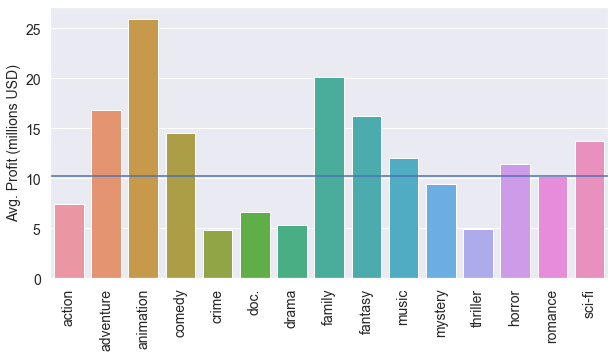

In [204]:
plt.clf()

genre_avg_profit = sns.barplot(x= genre_avg_df.index, y="avg_profit_millions", data=genre_avg_df)
genre_avg_profit.set_xticklabels(genre_avg_profit.get_xticklabels(),rotation=90,fontsize = 14)
genre_avg_profit.set_yticklabels([0,5,10,15,20,25], fontsize = 14)
genre_avg_profit.set_ylabel("Avg. Profit (millions USD)", fontsize = 14)
genre_avg_profit.set_xlabel('', fontsize = 18)
genre_avg_profit.axhline(movies['profit_millions'].mean())

sns.set(rc={'figure.figsize':(10,5)})

plt.savefig('barplot_avg_profit_genre.png', dpi = 100, bbox_inches = 'tight')

### Total outcome (sum) by genre

In [205]:
genre_sum = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).sum()
    x = x.rename_axis('genre', axis= 0)
    genre_sum = genre_sum.append(x)

genre_sum = genre_sum[genre_sum.index.str.contains("not")==False]
genre_sum = genre_sum[['budget_millions','gross_millions','profit_millions']]

In [206]:
# merge genre count and genre average outcome data into one df
genre_df_lst = [genre_sum, genre_count]

#directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)

genre_sum_df = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), genre_df_lst)
genre_sum_df = genre_sum_df.rename(columns = {'gross_millions': 'total_gross_millions',
                                             'budget_millions': 'total_budget_million',
                                              'profit_millions':'total_profit_millions',
                                     'color':'total_num'})
genre_sum_df = genre_sum_df.rename(index={'documentary':'doc.'})

genre_sum_df.sort_values(by = 'total_gross_millions', ascending = False)

#genre_df.to_csv('genre_df.csv')

,total_budget_million,total_gross_millions,total_profit_millions,count,pct_total
genre,,,,,
comedy,45223.5352,64321.3845,18097.0954,1460,0.150252
adventure,50598.1650,60196.8807,9654.6053,615,0.063291
action,52156.5100,56957.7346,5184.7316,791,0.081404
drama,46010.7508,53920.2620,7945.3610,1813,0.186580
thriller,38533.1744,42203.3871,4240.9283,1037,0.106720
fantasy,28333.7800,34349.5139,6142.6583,418,0.043017
family,26198.6840,33933.1085,7531.9909,419,0.043120
sci-fi,27445.3070,32544.5820,5212.7152,425,0.043738
romance,22463.4532,29550.5692,7062.3085,799,0.082227


#### barplot - total gross by genre

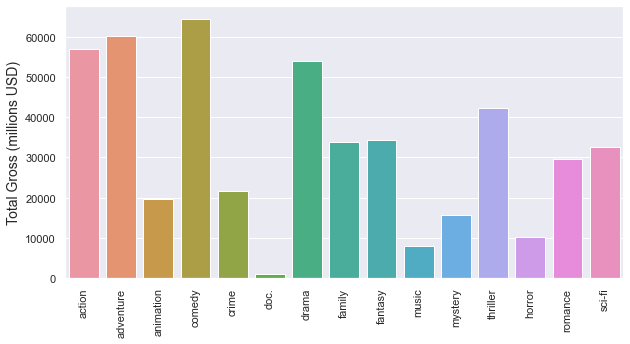

In [207]:
plt.clf()
genre_sum_gross = sns.barplot(x= genre_sum_df.index, y="total_gross_millions", data=genre_sum_df)
genre_sum_gross.set_xticklabels(genre_sum_gross.get_xticklabels(),rotation=90)
#genre_sum_gross.set_yticklabels([0,20,40,60,80,100], fontsize = 14)
genre_sum_gross.set_ylabel("Total Gross (millions USD)", fontsize = 14)
genre_sum_gross.set_xlabel('', fontsize = 14)
sns.set(rc={'figure.figsize':(10,5)})

plt.savefig('barplot_total_gross_genre.png', dpi = 100, bbox_inches = 'tight')

#### barplot - total profit by genre

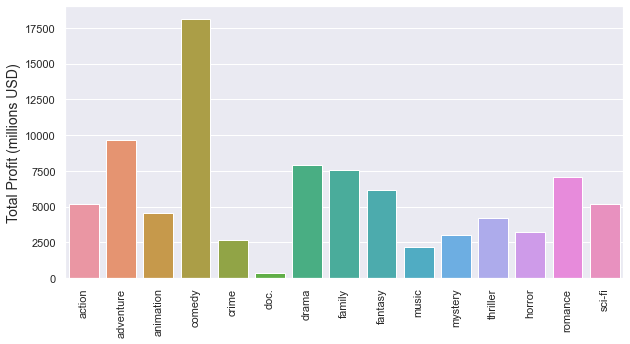

In [208]:
plt.clf()
genre_sum_profit = sns.barplot(x= genre_sum_df.index, y="total_profit_millions", data=genre_sum_df)
genre_sum_profit.set_xticklabels(genre_sum_profit.get_xticklabels(),rotation=90)
genre_sum_profit.set_ylabel("Total Profit (millions USD)", fontsize = 14)
genre_sum_profit.set_xlabel('', fontsize = 14)
sns.set(rc={'figure.figsize':(10,5)})
plt.savefig('barplot_total_profit_genre.png', dpi = 100, bbox_inches = 'tight')

## Keyword Analysis

Which keywords are associated with the greatest financial success?
<br>
<br>
**Method**<br>
(1) filter <code>movies</code>  to show only keywords that are associated with at least 30 movies; <br>
(2) calculate average outcomes per keyword. <br>
<br>
**Result**<br>
There are only 4 keywords with average normalized profit greater than the profit baseline, and 19 with average ROI greater than the ROI baseline. This indicates that there is likely large variation in the outcomes for any given keyword. Because the normalized profit and ROI analysis did not produce many keywords of interest, we will instead look at the highest grossing and most profitable keywords.

Highest grossing and most profitable keywords:
- Movies with the plot keywords 'sequel','battle','spy', 'alien', and 'island' the highest grossing, on average. 
- Movies with the plot keywords 'wedding', 'island', 'high school', 'female nudity', and 'hospital' are the most profitable, on average. 
- Movies with the plot keywords 'small town', 'writer', 'escape', 'scientist', 'boy', 'future', and 'box office flop' are not profitable, on average.

**Result**<br>
The plot keywords with the highest average gross and profit are likely to be associated with financially succesful films. Future films should consider these plot themes.

### Separate plot keywords; create binary variables for each keyword

In [222]:
# create list of plot keywords
movies['plot_keywords'] = movies['plot_keywords'].astype(str)
lst = movies['plot_keywords'].tolist()

# define empty list
lst_keywords = []

# split keywords on |; append keywords to lst_keywords
for i in lst:
    lst_keywords.append(i.split('|'))

# define function to flatten list of lists into one list 
# (function pulled from stack overflow: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists)
def flatten(t):
    return [item for sublist in t for item in sublist]

# apply flatten() to lst_keywords to create list of all keywords
keywords = pd.DataFrame(flatten(lst_keywords),columns=['keywords'])

17435

In [224]:
# define num_movies
num_movies = 30

#calculate value counts for each keyword
keyword_counts = keywords['keywords'].value_counts()

#create a list of keywords that are associated with at least 30 movies
keyword_lst = keyword_counts[keyword_counts >= num_movies].index.tolist()

#create a dataframe with keywords associated with 50 or more movies
keyword = movies[movies['plot_keywords'].isin(keyword_lst)]

keyword_counts

love                                      136
friend                                    126
murder                                    115
nan                                       111
death                                      93
                                         ... 
greek restaurant                            1
baseball team                               1
adaptation directed by original author      1
desert storm                                1
edwardian era                               1
Name: keywords, Length: 6612, dtype: int64

In [211]:
# add binary keyword variable to movies df
movies_kw = movies

# create column for each genre in genre_lst
for x in keyword_lst:
    movies_kw['keyword_' + x.lower()] = ""

# populate columns with binary field
for x in range(len(movies_kw['plot_keywords'])):
    for y in keyword_lst:
        if y in movies_kw['plot_keywords'][x]:
            movies_kw['keyword_' + y.lower()][x] = y.lower()
        else:
            movies_kw['keyword_' + y.lower()][x] = 'not ' + y.lower()

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


### Analyze average outcome by keyword

In [212]:
kw_avg = pd.DataFrame()
for x in keyword_lst:
    x = movies_kw.groupby(['keyword_' + x.lower()]).mean()
    x = x.rename_axis('keyword', axis= 0)
    kw_avg = kw_avg.append(x)

kw_avg = kw_avg[kw_avg.index.str.contains("not")==False]

kw_avg = kw_avg[['budget_millions','gross_millions','profit_millions','roi']]

In [227]:
kw_avg.sort_values(by = 'profit_millions', ascending = False).head()

,budget_millions,gross_millions,profit_millions,roi,profit_pct_mean
keyword,,,,,
wedding,28.698864,51.316095,24.116329,0.734712,2.362996
island,46.929762,70.969746,23.616500,0.296208,2.314022
high school,18.035000,38.581123,22.418203,6.621748,2.196608
female nudity,20.799730,40.099836,22.259837,1.104193,2.181091
hospital,27.102500,49.144468,21.050572,1.069265,2.062604


In [228]:
kw_avg.sort_values(by = 'roi', ascending = False).head()

,budget_millions,gross_millions,profit_millions,roi,profit_pct_mean
keyword,,,,,
high school,18.035000,38.581123,22.418203,6.621748,2.196608
school,19.177037,37.312667,19.522719,3.935039,1.912900
secret,35.690234,49.770390,12.971335,3.528935,1.270974
serial killer,28.538485,36.545540,6.777207,2.530252,0.664053
friendship,19.484174,35.325161,19.730798,2.347542,1.933288


In [215]:
# calculate percent difference from mean
kw_avg['profit_pct_mean'] = (kw_avg['profit_millions']/ movies['profit_millions'].mean())
kw_profit_pct_mean = kw_avg[kw_avg['profit_pct_mean'] > profit_baseline] 

In [216]:
kw_profit_pct_mean.sort_values(by = 'roi', ascending = False).head()

,budget_millions,gross_millions,profit_millions,roi,profit_pct_mean
keyword,,,,,
high school,18.035000,38.581123,22.418203,6.621748,2.196608
female nudity,20.799730,40.099836,22.259837,1.104193,2.181091
wedding,28.698864,51.316095,24.116329,0.734712,2.362996
island,46.929762,70.969746,23.616500,0.296208,2.314022


In [217]:
kw_profit_pct_mean.count()

budget_millions    4
gross_millions     4
profit_millions    4
roi                4
profit_pct_mean    4
dtype: int64

In [218]:
kw_roi = kw_avg[kw_avg['roi'] > roi_baseline] 

In [219]:
kw_roi.sort_values(by = 'roi', ascending = False).head(5)

,budget_millions,gross_millions,profit_millions,roi,profit_pct_mean
keyword,,,,,
high school,18.035000,38.581123,22.418203,6.621748,2.196608
school,19.177037,37.312667,19.522719,3.935039,1.912900
secret,35.690234,49.770390,12.971335,3.528935,1.270974
serial killer,28.538485,36.545540,6.777207,2.530252,0.664053
friendship,19.484174,35.325161,19.730798,2.347542,1.933288


In [220]:
kw_roi.count()

budget_millions    19
gross_millions     19
profit_millions    19
roi                19
profit_pct_mean    19
dtype: int64

# Ideas for additional analysis

- How successful are sequels and series'?
<br>
- Closer look at popular groupings of genres (i.e. romance and comedy; action and adventure).
<br>
- Closer look at popular groupings of keywords. 
- Group similar keywords together.
- Analysis of outcomes by content rating.